# Diffusion with Chemical Reaction in a One-Dimensional Slab
This is the seventh problem of the famous set of [Ten Problems in Chemical Engineering](https://www.polymath-software.com/ASEE/Tenprobs.pdf).  Here, the goal is to solve second order ordinary differential equations with two point boundary conditions

Jacob Albrecht, 2019

# Problem Setup

For a first order irreversible reaction ($A \rightarrow B$) occuring in a 1D domain, the concentration of species $A$ is governed by the differential equation:

$$\frac{d^2C_A}{dz^2} = \frac{k}{D_{AB}}C_A$$

at location $z = 0$, the boundary condition is:

$$C_A = C_{A0}$$

at the other edge of the domain, $z = L$, the condition is:

$$\frac{dC_A}{dz} = 0$$

# Problem Tasks

a)Numerically solve the differential equation with the boundary conditions with 

$C_{A0} = 0.2 kg\cdot mol/m^3$

$k = 10^{-3} s^{-1}$

$D_{AB} = 1.2\cdot10^{-9} m^2/s$ 

$L = 10^{-3} m$ 

This solution should  utilize an  ODE  solver  with  a  shooting  technique  and  employ  Newton’s  method  or some other technique for converging on the boundary condition.

b) Compare the concentration profiles over the thickness as predicted by the numerical solution of (a) with the analytical solution of the differential equation.

# Solutions
## Solution to part a)

Rewriting the second-order differential equation and boundary conditions as a set of first-order equations will allow for the use of the scipy integration functions, following [the approach here](https://polymath-software.com/ASEE/Matlab/Matlab.pdf).

$$y_2 = \frac{dC_A}{dz}$$

At $z = 0$, $y_2$ will have an unknown value $\alpha$.  Define new quantities $y_3$ and $y_4$ to incorporate the boundary conditions and to solve for $\alpha$ by the shooting technique

$$y_3 = \frac{\partial C_A}{\partial \alpha}$$

$$y_4 = \frac{dy_3}{dz}$$

$$\frac{dy_4}{dz} = \frac{ky_3}{D_{AB}}$$

The initial conditions for $C_A$, $y_2$, $y_3$, and $y_4$ are $C_{A0}$, $\alpha$, $0$, and $1$, respectively

In [1]:
import numpy as np
from scipy.optimize import newton
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define function for solving the expanded ode:
def odefun(t,y):
    dy = np.zeros(4)
    dy[0] = y[1]
    dy[1] = k*y[0]/Dab
    dy[2] = y[3]
    dy[3] = k*y[2]/Dab
    return(dy)

# define function for optimizing α
def objfun(alpha):
    y0 = np.array([CA0,alpha,0,1])    
    sol = solve_ivp(odefun,tspan,y0)
    err = sol.y[1,-1]/sol.y[3,-1]
    return(err)

# define constants:
L=1e-3
CA0 = 0.2
k = 1e-2
Dab = 1.210e-9
alpha=0

# set integration range:
tspan = [0,L]

# run optimization
opt_α = newton(objfun,alpha)

# use optimal α to calculate profile:
y0 = np.array([CA0,opt_α,0,1])
t_eval = np.linspace(0,L,num=25)
numerical_sol = solve_ivp(odefun,tspan,y0,t_eval=t_eval)
err = numerical_sol.y[1,-1]/numerical_sol.y[3,-1]

print('Optimal \u03B1: {:.4}'.format(opt_α)) # unicode is ok with python
print('Final error: {:.2}'.format(err))

Optimal α: -571.3
Final error: 5e-14


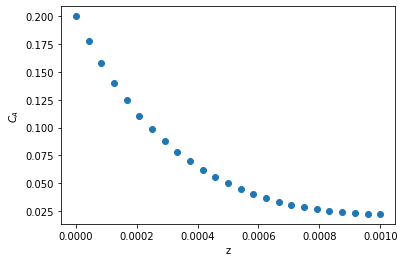

In [3]:
plt.plot(numerical_sol.t,numerical_sol.y[0,:],'o')
plt.xlabel('z')
plt.ylabel('$C_A$');

## Solution to part b)
Instead of using the analytical expression given in the problem statement, we will use `sympy` to calculate the analytical solution from the differential equation and boundary conditions.

In [4]:
from sympy import symbols, Function, Eq, dsolve, Derivative, lambdify

k, D_AB, z, L, C_A0 = symbols('k D_AB z L C_A0')

C = Function('C')

deq = Eq(Derivative(C(z),(z,2))-k/D_AB*C(z))

Inspect the differential equation from sympy:

In [5]:
deq

Eq(Derivative(C(z), (z, 2)) - k*C(z)/D_AB, 0)

Solve the differential equation with the boundary conditions and view the output:

In [6]:
analytical_sol = dsolve(deq,ics={C(0):C_A0,
                      Derivative(C(L),L):0})

In [7]:
analytical_sol

Eq(C(z), C_A0*exp(2*L*sqrt(k/D_AB))*exp(-z*sqrt(k/D_AB))/(exp(2*L*sqrt(k/D_AB)) + 1) + C_A0*exp(z*sqrt(k/D_AB))/(exp(2*L*sqrt(k/D_AB)) + 1))

Substitute in the constant values from the problem statement:

In [8]:
C = analytical_sol.subs({C_A0:0.2,L:1e-3,D_AB:1.210e-9,k:1e-2})
C

Eq(C(z), 0.00063479232011981*exp(2874.79787288035*z) + 0.19936520767988*exp(-2874.79787288035*z))

In [9]:
# convert the sympy expression to numpy for plotting
lam_C = lambdify(z,C.rhs, 'numpy')
lam_z = np.linspace(0,1e-3,num=100)

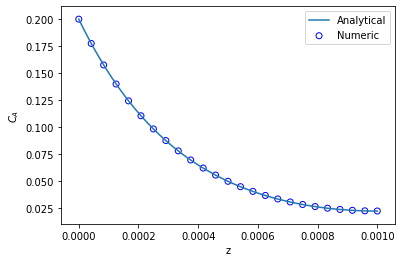

In [10]:
plt.plot(lam_z,lam_C(lam_z),label= 'Analytical')
plt.scatter(numerical_sol.t,numerical_sol.y[0,:],facecolors='none',edgecolors='b',label='Numeric')
plt.xlabel('z')
plt.ylabel('$C_A$')
plt.legend()
plt.show()


The analytical and numeric solutions match perfectly.  Calculus FTW.

# Reference
“The Use of Mathematical Software packages in Chemical Engineering”, Michael B. Cutlip, John J. Hwalek, Eric H.
Nuttal, Mordechai Shacham, Workshop Material from Session 12, Chemical Engineering Summer School, Snowbird,
Utah, Aug., 1997.

In [11]:
%load_ext watermark
%watermark -v -p scipy,matplotlib,numpy,sympy

CPython 3.7.3
IPython 7.6.1

scipy 1.3.0
matplotlib 3.1.0
numpy 1.16.4
sympy 1.4
